# UVA-ARC-Alaska data exploration

This is a notebook with example code for generating graphs to identify faulty instruments and data gaps.

## First step: loading dependencies and helper functions

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import datetime
import h5pyd
import time

In [35]:
#
# Settings for plotting graphs
#
%matplotlib inline
#
# Determine graph size
sns.set(rc={'figure.figsize':(18, 8)})
#
# Disable future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load HDF data store

In [36]:
#
# Load the datastore from HSDS:
# All the data generated up until now from the sensor net in Alaska
#
filepath = "hdf5://home/test.h5"

In [37]:
#
# Open HSDS datastore as 'f'
#
# Please note:
# Set use_cache to False to pick up any real-time changes
# This is useful if the analyst wants to include latest data batch
#
f = h5pyd.File(filepath, mode='r', use_cache=True)

In [38]:
#
# Useful functions:
# Show HDF5 attributes
#
# You can just load this box w/ SHIFT+ENTER and move on
# These functions will be used later to convert between data formats
# 
def read_attrs(obj):
    for k in obj.attrs:
        v = obj.attrs[k]
        print(f"{k}: {v}")
        
#
# Convert timestamp (ts) in seconds to a date-time string
# Note: in the database, all datetime is stored in seconds 
#
def ts_to_str(ts):
    value = datetime.datetime.utcfromtimestamp(ts)
    s = value.isoformat(sep=' ', timespec='seconds')
    return s

#
# Convert datetime string to timestamp int
#
def str_to_ts(datestr):
    date_fmt = "%Y-%m-%d %H:%M:%S"
    # Remove suffix for UTC
    # No TZ support: UTC always assumed
    if datestr[-1] == "Z":
        datestr = datestr[:-1]
    date = datetime.datetime.strptime(datestr, date_fmt)    
    date_utc = date.astimezone
    ts = int(date.timestamp())  # Truncating to int
    return ts

#
# Convert np bytestring values to string
# to make things easier when working with dataframes
# 
def convert_bytestr_to_str(df):
    df_converted = df
    for col, dtype in df.dtypes.items():
        if dtype == object:
            df[col] = df[col].str.decode('utf-8')
    return df_converted

In [39]:
#
# Read loggers / stations
#
loggers = f["loggers"]

#
# Display logger name, number, and last time they were updated
#
for i in range(loggers.nrows):
    row = loggers[i]
    logger_name = row['name'].decode('utf-8')
    logger_sn = row['sn'].decode('utf-8')
    last_query_ts = row['last_query']
    last_query_datestr = ts_to_str(last_query_ts)
    print(f"name: {logger_name}, logger number: {logger_sn}, last query run: {last_query_datestr}")

name: TNHA-B01, logger number: 21198259, last query run: 2022-12-31 23:59:59
name: TNHA-B01, logger number: 21401799, last query run: 2022-12-31 23:59:59
name: BUECI-B01, logger number: 21401800, last query run: 2022-12-31 23:59:59
name: SSMH-B01, logger number: 21401801, last query run: 2022-12-31 23:59:59
name: BEO-B01, logger number: 21401802, last query run: 2022-12-31 23:59:59
name: SSMH-B01, logger number: 21401803, last query run: 2022-12-31 23:59:59


## Reading the data table on HSDS

In [40]:
# 
# Reading sensor data
# Now that we can get all the relevant info about the stations + sensors
# First, let's read the dataset and pass to a variable called 'data'
# 
data_table = f['data']

# Let's see the dimensions of the dataset
#
data_table

<HDF5 dataset "data": shape (2006065,), type "|V48">

In [41]:
#
# How to read the output above?
# Well, look at "shape" and you will see that is has 2006065 data points
#
# Now we need to convert from numpy array to Pandas dataframe
# That is much easier to manipulate, plot, etc.
#
# Note:
# Using "%time" before any instruction tells us the time spent
#
arr = data_table.value
df = pd.DataFrame(arr)
%time df

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.29 µs


logger_sn      sensor_sn  data_type_id  measurement_type  \
0        b'21198259'  b'21143416-1'             1                 5   
1        b'21198259'  b'21167037-1'             1                 8   
2        b'21198259'  b'21176452-1'             1                 4   
3        b'21198259'  b'21176526-1'             1                 3   
4        b'21198259'  b'21176861-1'             1                 9   
...              ...            ...           ...               ...   
2006060  b'21401803'  b'21401803-B'             1                11   
2006061  b'21401803'  b'21401803-B'             1                11   
2006062  b'21401803'  b'21401803-B'             1                11   
2006063  b'21401803'  b'21401803-B'             1                11   
2006064  b'21401803'  b'21401803-B'             1                11   

            si_value   timestamp  
0           0.000000  1661990400  
1         217.607843  1661990400  
2        1000.049980  1661990400  
3         115.625000  1661990400  
4           5.535976  1661990400  
...              ...         ...  
2006060     3.898087  1672461306  
2006061     3.899590  1672461606  
2006062     3.898087  1672461906  
2006063     3.899590  1672462206  
2006064     3.899590  1672462506  

[2006065 rows x 6 columns]

In [42]:
#
# Look into the dataframe, just the first 10 lines!
# This operation is aesthetic and takes a bit of time,
# because it traverses the df to convert the strings...
# each bytestr (from numpy format) into regular Python str
#
# Aesthetics matters... for the modic wait of 18 seconds
# 
df = convert_bytestr_to_str(df)
%time df

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


logger_sn   sensor_sn  data_type_id  measurement_type     si_value  \
0        21198259  21143416-1             1                 5     0.000000   
1        21198259  21167037-1             1                 8   217.607843   
2        21198259  21176452-1             1                 4  1000.049980   
3        21198259  21176526-1             1                 3   115.625000   
4        21198259  21176861-1             1                 9     5.535976   
...           ...         ...           ...               ...          ...   
2006060  21401803  21401803-B             1                11     3.898087   
2006061  21401803  21401803-B             1                11     3.899590   
2006062  21401803  21401803-B             1                11     3.898087   
2006063  21401803  21401803-B             1                11     3.899590   
2006064  21401803  21401803-B             1                11     3.899590   

          timestamp  
0        1661990400  
1        1661990400  
2        1661990400  
3        1661990400  
4        1661990400  
...             ...  
2006060  1672461306  
2006061  1672461606  
2006062  1672461906  
2006063  1672462206  
2006064  1672462506  

[2006065 rows x 6 columns]

## Timestamp conversion

In [43]:
%%time
#
# Convert the time coordinate (in seconds, Unix epoch) to datetime
# Now we can work happily with normal date-time, not seconds
#
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
df = df.set_index('timestamp')
df

CPU times: user 204 ms, sys: 0 ns, total: 204 ms
Wall time: 204 ms


logger_sn   sensor_sn  data_type_id  \
timestamp                                                       
2022-09-01 00:00:00+00:00  21198259  21143416-1             1   
2022-09-01 00:00:00+00:00  21198259  21167037-1             1   
2022-09-01 00:00:00+00:00  21198259  21176452-1             1   
2022-09-01 00:00:00+00:00  21198259  21176526-1             1   
2022-09-01 00:00:00+00:00  21198259  21176861-1             1   
...                             ...         ...           ...   
2022-12-31 04:35:06+00:00  21401803  21401803-B             1   
2022-12-31 04:40:06+00:00  21401803  21401803-B             1   
2022-12-31 04:45:06+00:00  21401803  21401803-B             1   
2022-12-31 04:50:06+00:00  21401803  21401803-B             1   
2022-12-31 04:55:06+00:00  21401803  21401803-B             1   

                           measurement_type     si_value  
timestamp                                                 
2022-09-01 00:00:00+00:00                 5     0.000000  
2022-09-01 00:00:00+00:00                 8   217.607843  
2022-09-01 00:00:00+00:00                 4  1000.049980  
2022-09-01 00:00:00+00:00                 3   115.625000  
2022-09-01 00:00:00+00:00                 9     5.535976  
...                                     ...          ...  
2022-12-31 04:35:06+00:00                11     3.898087  
2022-12-31 04:40:06+00:00                11     3.899590  
2022-12-31 04:45:06+00:00                11     3.898087  
2022-12-31 04:50:06+00:00                11     3.899590  
2022-12-31 04:55:06+00:00                11     3.899590  

[2006065 rows x 5 columns]

In [44]:
#
# Slice the dataframe as needed: for instance:
# By specifying the time interval (in UTC)
# 
# Let's start with the first day in the UVA-ARC dataset:
# We can include hour:minute:second precision, if needed
# 
df_time_interval = df.loc['2022-08-01 00:00:00':'2022-12-31 23:59:59']
df_time_interval

logger_sn   sensor_sn  data_type_id  \
timestamp                                                       
2022-09-01 00:00:00+00:00  21198259  21143416-1             1   
2022-09-01 00:00:00+00:00  21198259  21167037-1             1   
2022-09-01 00:00:00+00:00  21198259  21176452-1             1   
2022-09-01 00:00:00+00:00  21198259  21176526-1             1   
2022-09-01 00:00:00+00:00  21198259  21176861-1             1   
...                             ...         ...           ...   
2022-12-31 04:35:06+00:00  21401803  21401803-B             1   
2022-12-31 04:40:06+00:00  21401803  21401803-B             1   
2022-12-31 04:45:06+00:00  21401803  21401803-B             1   
2022-12-31 04:50:06+00:00  21401803  21401803-B             1   
2022-12-31 04:55:06+00:00  21401803  21401803-B             1   

                           measurement_type     si_value  
timestamp                                                 
2022-09-01 00:00:00+00:00                 5     0.000000  
2022-09-01 00:00:00+00:00                 8   217.607843  
2022-09-01 00:00:00+00:00                 4  1000.049980  
2022-09-01 00:00:00+00:00                 3   115.625000  
2022-09-01 00:00:00+00:00                 9     5.535976  
...                                     ...          ...  
2022-12-31 04:35:06+00:00                11     3.898087  
2022-12-31 04:40:06+00:00                11     3.899590  
2022-12-31 04:45:06+00:00                11     3.898087  
2022-12-31 04:50:06+00:00                11     3.899590  
2022-12-31 04:55:06+00:00                11     3.899590  

[2006065 rows x 5 columns]

# Filtering for sensor types

In [45]:
#
# We may want to select 'temp' sensors in this time slice
# Let's select the slice with the .isin() method
# Just for the measurement type '1' (temperature)
#
df_temp = df_time_interval.loc[df_time_interval['measurement_type'].isin([1])]
# 
# Min and max values
#
print('Max. value, station / sensor:')
print(df_temp.max())
print('\n')
print('Min. value, station / sensor:')
print(df_temp.min())

Max. value, station / sensor:
logger_sn             21401803
sensor_sn           21398676-1
data_type_id                 1
measurement_type             1
si_value             128.82979
dtype: object


Min. value, station / sensor:
logger_sn             21198259
sensor_sn           21187245-1
data_type_id                 1
measurement_type             1
si_value            -30.442351
dtype: object


In [46]:
#
# List the temperature sensors
# 
df_temp['sensor_sn'].unique()

array(['21206939-10', '21206939-15', '21206939-16', '21206939-12',
       '21206939-13', '21206939-14', '21206939-17', '21206939-9',
       '21206939-11', '21206939-7', '21206939-8', '21398666-1',
       '21398674-1', '21398676-1', '21380919-1', '21398601-14',
       '21398601-15', '21398601-16', '21398601-10', '21398601-12',
       '21398601-13', '21398601-17', '21398601-8', '21393047-10',
       '21393047-11', '21393047-16', '21393047-7', '21393047-8',
       '21398601-11', '21398601-7', '21398601-9', '21393047-12',
       '21393047-13', '21393047-14', '21393047-15', '21393047-17',
       '21393047-9', '21218018-1', '21398593-12', '21398593-14',
       '21398593-15', '21398593-17', '21398593-10', '21398593-11',
       '21398593-16', '21398593-7', '21398593-8', '21398593-9',
       '21398593-13', '21398670-1', '21215426-1', '21393049-8',
       '21398665-1', '21393049-11', '21393049-13', '21393049-15',
       '21393049-17', '21393049-9', '21390849-1', '21393049-10',
       '21393049-1

In [47]:
#
# Nice, but... we have a new type of temp sensor now:
# Soil temp sensor and their numbering system is different (-7 to -17)
# So, we filter them out to only get atmos. temperature
# 
df_atmos_temp = df_temp[df_temp['sensor_sn'].str.endswith('-1')]
df_atmos_temp

logger_sn   sensor_sn  data_type_id  \
timestamp                                                       
2022-09-01 00:00:00+00:00  21198259  21398666-1             1   
2022-09-01 00:00:00+00:00  21198259  21398674-1             1   
2022-09-01 00:00:00+00:00  21198259  21398676-1             1   
2022-09-01 00:00:00+00:00  21198259  21380919-1             1   
2022-09-01 00:00:00+00:00  21198259  21218018-1             1   
...                             ...         ...           ...   
2022-12-31 02:30:00+00:00  21401803  21397541-1             1   
2022-12-31 03:00:00+00:00  21401803  21397541-1             1   
2022-12-31 03:30:00+00:00  21401803  21397541-1             1   
2022-12-31 04:00:00+00:00  21401803  21397541-1             1   
2022-12-31 04:30:00+00:00  21401803  21397541-1             1   

                           measurement_type   si_value  
timestamp                                               
2022-09-01 00:00:00+00:00                 1   3.836812  
2022-09-01 00:00:00+00:00                 1   3.965513  
2022-09-01 00:00:00+00:00                 1   4.137114  
2022-09-01 00:00:00+00:00                 1   4.501768  
2022-09-01 00:00:00+00:00                 1   3.960088  
...                                     ...        ...  
2022-12-31 02:30:00+00:00                 1 -17.530713  
2022-12-31 03:00:00+00:00                 1 -17.766640  
2022-12-31 03:30:00+00:00                 1 -17.573608  
2022-12-31 04:00:00+00:00                 1 -17.487817  
2022-12-31 04:30:00+00:00                 1 -17.380577  

[82301 rows x 5 columns]

In [48]:
# 
# Looks great, now list all sensors
#
df_atmos_temp['sensor_sn'].unique()
#
# Result: 
# 21 atmos. temp. sensors
#

array(['21398666-1', '21398674-1', '21398676-1', '21380919-1',
       '21218018-1', '21398670-1', '21215426-1', '21398665-1',
       '21390849-1', '21397541-1', '21398664-1', '21397542-1',
       '21398659-1', '21398668-1', '21398660-1', '21398661-1',
       '21187245-1'], dtype=object)

# Timezone adjustment

In [49]:
#
# p.s.
# To graphs that people can undestand, we need to adjust the timezone
# 
df_atmos_temp = df_atmos_temp.tz_convert(tz='America/Anchorage')
df_atmos_temp

logger_sn   sensor_sn  data_type_id  \
timestamp                                                       
2022-08-31 16:00:00-08:00  21198259  21398666-1             1   
2022-08-31 16:00:00-08:00  21198259  21398674-1             1   
2022-08-31 16:00:00-08:00  21198259  21398676-1             1   
2022-08-31 16:00:00-08:00  21198259  21380919-1             1   
2022-08-31 16:00:00-08:00  21198259  21218018-1             1   
...                             ...         ...           ...   
2022-12-30 17:30:00-09:00  21401803  21397541-1             1   
2022-12-30 18:00:00-09:00  21401803  21397541-1             1   
2022-12-30 18:30:00-09:00  21401803  21397541-1             1   
2022-12-30 19:00:00-09:00  21401803  21397541-1             1   
2022-12-30 19:30:00-09:00  21401803  21397541-1             1   

                           measurement_type   si_value  
timestamp                                               
2022-08-31 16:00:00-08:00                 1   3.836812  
2022-08-31 16:00:00-08:00                 1   3.965513  
2022-08-31 16:00:00-08:00                 1   4.137114  
2022-08-31 16:00:00-08:00                 1   4.501768  
2022-08-31 16:00:00-08:00                 1   3.960088  
...                                     ...        ...  
2022-12-30 17:30:00-09:00                 1 -17.530713  
2022-12-30 18:00:00-09:00                 1 -17.766640  
2022-12-30 18:30:00-09:00                 1 -17.573608  
2022-12-30 19:00:00-09:00                 1 -17.487817  
2022-12-30 19:30:00-09:00                 1 -17.380577  

[82301 rows x 5 columns]

# Select Station/Logger

In [17]:
#
# This is great, but we only want to analyze one station now
# Say TNHA-B1, logger_sn: 21198259
# 
df_tnha = df_atmos_temp[df_atmos_temp['logger_sn']=='21198259']
df_tnha

logger_sn   sensor_sn  data_type_id  \
timestamp                                                       
2022-08-31 16:00:00-08:00  21198259  21398666-1             1   
2022-08-31 16:00:00-08:00  21198259  21398674-1             1   
2022-08-31 16:00:00-08:00  21198259  21398676-1             1   
2022-08-31 16:00:00-08:00  21198259  21380919-1             1   
2022-08-31 16:00:00-08:00  21198259  21218018-1             1   
...                             ...         ...           ...   
2022-12-27 19:30:00-09:00  21198259  21380919-1             1   
2022-12-27 19:30:00-09:00  21198259  21218018-1             1   
2022-12-27 19:30:00-09:00  21198259  21398664-1             1   
2022-12-27 20:00:00-09:00  21198259  21218018-1             1   
2022-12-27 20:30:00-09:00  21198259  21218018-1             1   

                           measurement_type   si_value  
timestamp                                               
2022-08-31 16:00:00-08:00                 1   3.836812  
2022-08-31 16:00:00-08:00                 1   3.965513  
2022-08-31 16:00:00-08:00                 1   4.137114  
2022-08-31 16:00:00-08:00                 1   4.501768  
2022-08-31 16:00:00-08:00                 1   3.960088  
...                                     ...        ...  
2022-12-27 19:30:00-09:00                 1 -21.924873  
2022-12-27 19:30:00-09:00                 1 -21.927533  
2022-12-27 19:30:00-09:00                 1 -21.924873  
2022-12-27 20:00:00-09:00                 1 -22.056221  
2022-12-27 20:30:00-09:00                 1 -22.184908  

[31324 rows x 5 columns]

In [18]:
#
# This is all good, but notice that HOBO provides timestamps in a non-monotonic manner
# HOBOs are erractic, as we know...
#
# So, we need to resample: by hour, day, week, etc.
# In the case below: daily mean temperatures to plot nice graphs
#
df_day = df_tnha.resample('D').mean()
df_day

data_type_id  measurement_type   si_value
timestamp                                                           
2022-08-31 00:00:00-08:00           1.0               1.0   3.924748
2022-09-01 00:00:00-08:00           1.0               1.0   3.734023
2022-09-02 00:00:00-08:00           1.0               1.0   3.107509
2022-09-03 00:00:00-08:00           1.0               1.0   4.607115
2022-09-04 00:00:00-08:00           1.0               1.0   4.204662
...                                 ...               ...        ...
2022-12-23 00:00:00-09:00           1.0               1.0 -13.231959
2022-12-24 00:00:00-09:00           1.0               1.0 -15.875958
2022-12-25 00:00:00-09:00           1.0               1.0 -24.621928
2022-12-26 00:00:00-09:00           1.0               1.0 -22.747772
2022-12-27 00:00:00-09:00           1.0               1.0 -21.588326

[119 rows x 3 columns]

# Plotting mean values per station

<AxesSubplot:xlabel='timestamp', ylabel='si_value'>

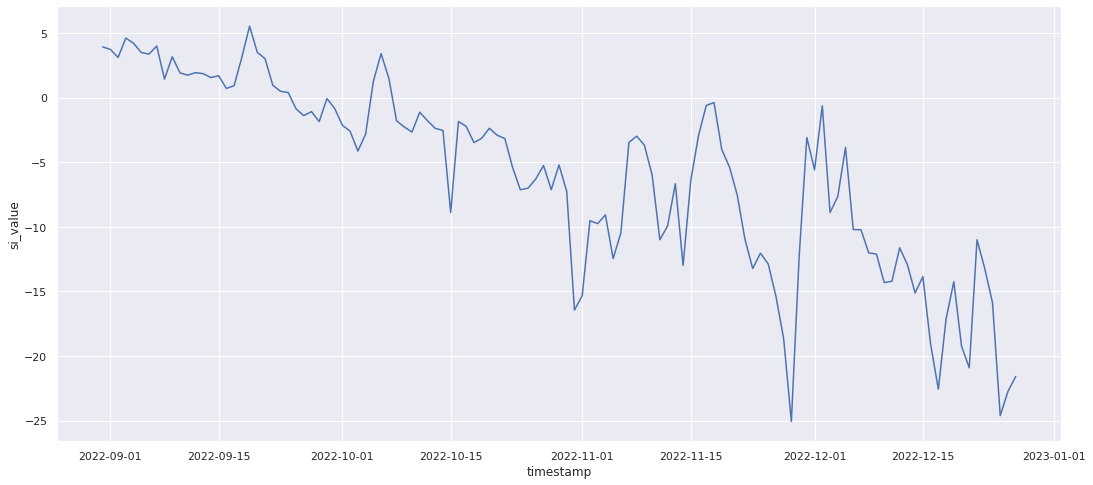

In [19]:
#
# Let's plot the temp sensors for the period!
# We use:
# 'timestamp' column for timestamps of the timeseries
# 'si_value' where the sensor values are
# 'data' with the dataframe we generated in the previous box 'df_day'
# 
# Here we have a line graph with mean atmos. temp. for TNHA-B01:
# 
sns.lineplot(x='timestamp', y='si_value', data=df_day)

<AxesSubplot:xlabel='timestamp', ylabel='si_value'>

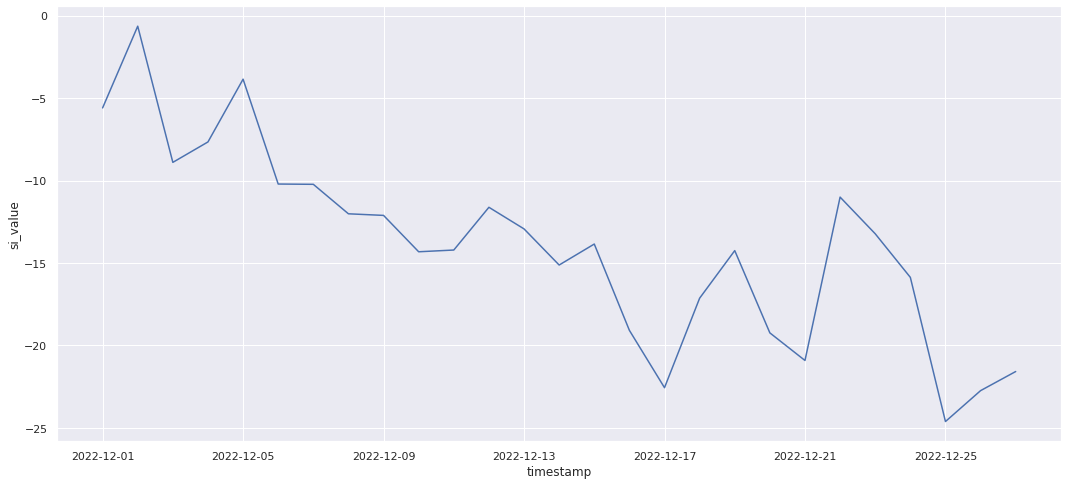

In [20]:
#
# Zoom in a particular month for more details!
# Mean temp for December, 2022
#
df_december = df_day['2022-12']
sns.lineplot(x='timestamp', y='si_value', data=df_december)

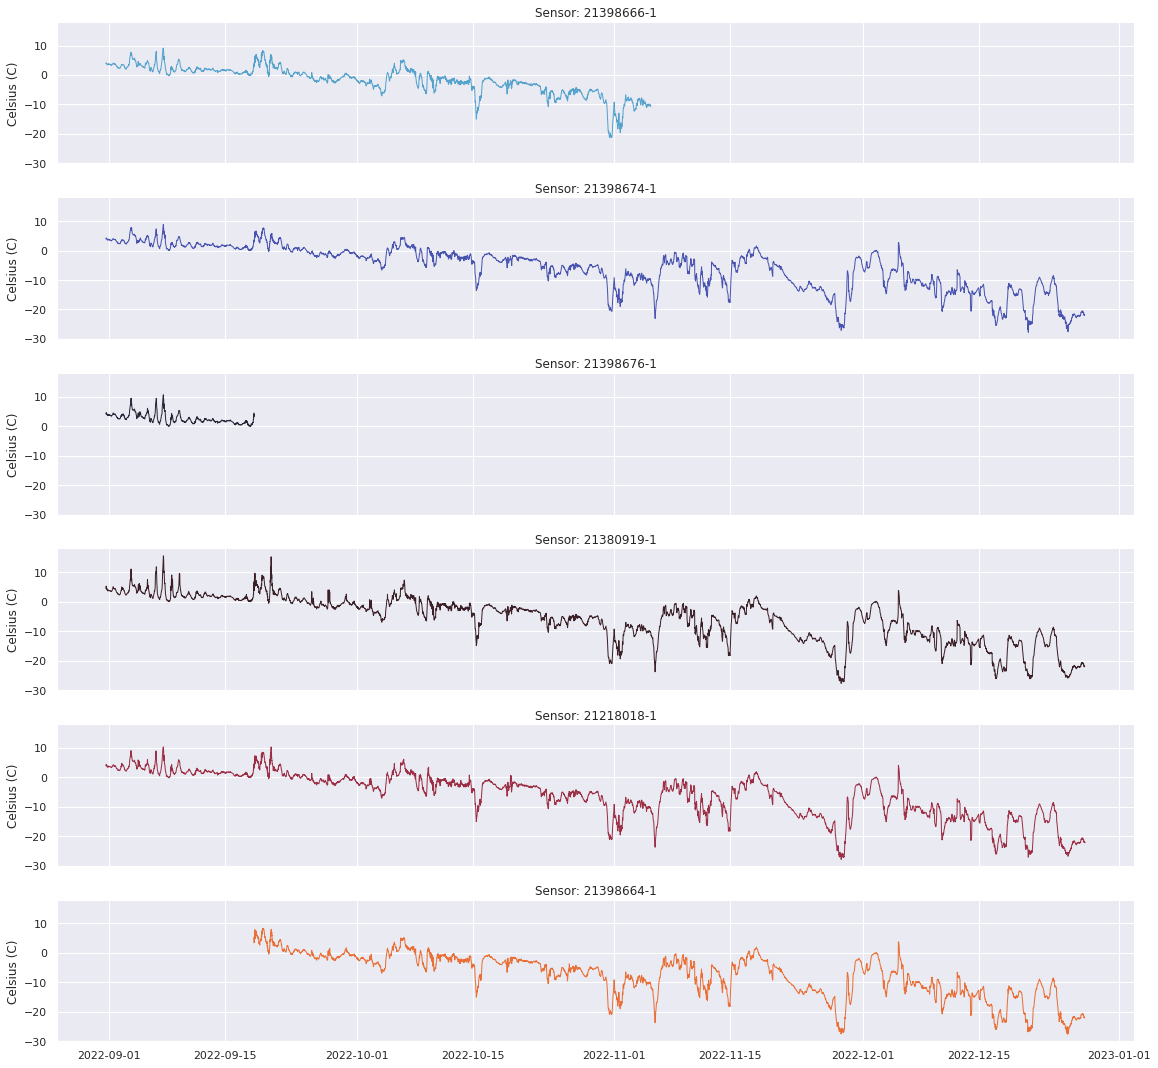

In [21]:
#
# Plot individual sensors for comparison: 
#
graph = sns.relplot(x='timestamp', 
                    y='si_value', 
                    col='sensor_sn', 
                    hue='sensor_sn', 
                    data=df_tnha,
                    kind='line',
                    linewidth=1.0,
                    palette='icefire',
                    col_wrap=1,
                    legend=False, 
                    height=2.5, 
                    aspect=6.5)
# Tweak the aspects of the plot
graph.set_titles('Sensor: {col_name}')
graph.set_axis_labels('', 'Celsius (C)')
graph.tight_layout()

# Generating heatmaps with sensor data

In [22]:
#
# Resampling to 1 day, so the graph is legible
#
df_temp = df_tnha['2022-09'].groupby('sensor_sn').resample('1D').mean()
df_temp = df_temp.reset_index()
df_temp = df_temp.set_index('timestamp')
#
# Extra step, so we can pivot for generating the heatmap graph
df_temp = df_temp.reset_index()
df_temp['timestamp'] =  df_temp['timestamp'].dt.strftime('%m/%d')

Text(0.5, 1.0, 'TNHA-B01 - September, 2022')

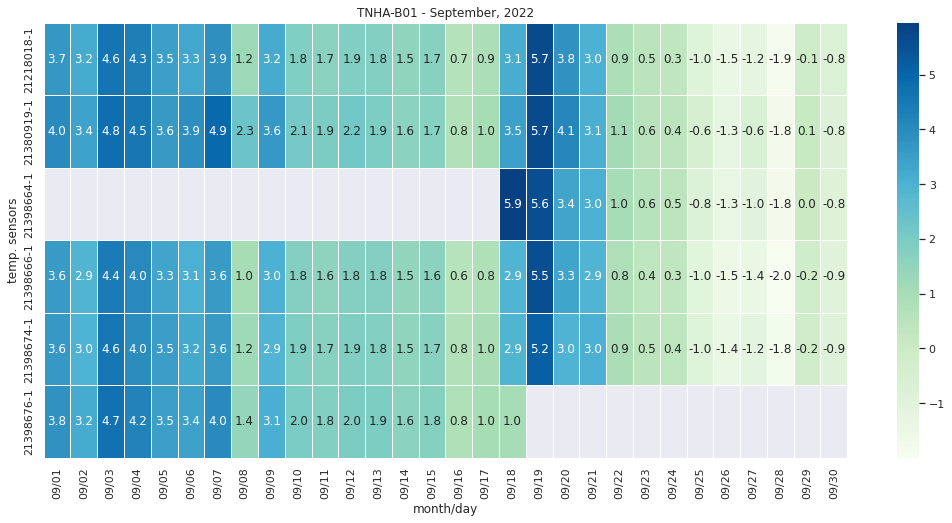

In [23]:
#
# Generate the heatmap
df_heatmap = df_temp.pivot_table(index='sensor_sn', 
                                 columns='timestamp',
                                 values='si_value')

graph = sns.heatmap(df_heatmap, annot=True, 
                                fmt='.1f', 
                                linewidth=.5,
                                cmap='GnBu')
# Adjust xy axis labels
plt.xlabel("month/day")
plt.ylabel("temp. sensors")
graph.set_title('TNHA-B01 - September, 2022')

Text(0.5, 1.0, 'TNHA-B01 - October, 2022')

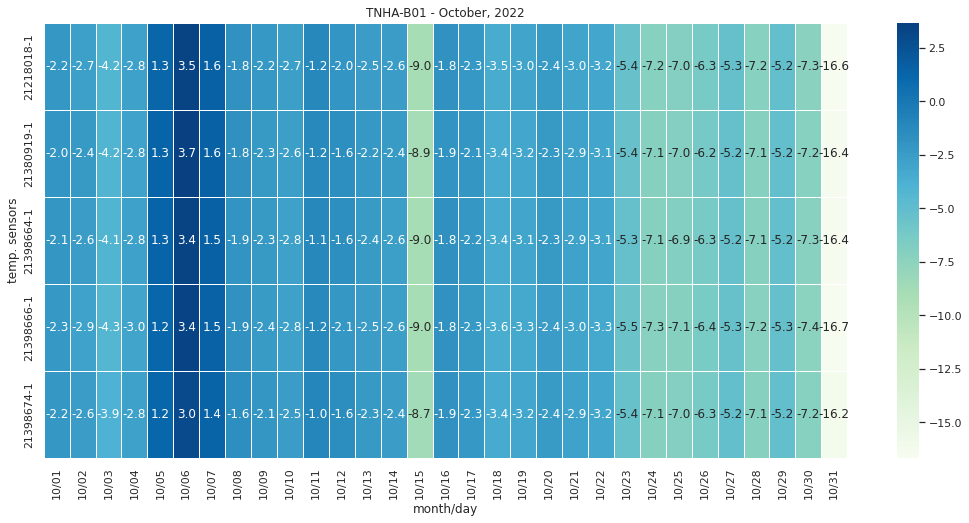

In [27]:
# 
# Neat! 
# Now let's generate the same graph for the next month, October
#
df_temp = df_tnha['2022-10'].groupby('sensor_sn').resample('1D').mean()
df_temp = df_temp.reset_index()
df_temp = df_temp.set_index('timestamp')
df_temp = df_temp.reset_index()
df_temp['timestamp'] =  df_temp['timestamp'].dt.strftime('%m/%d')
df_heatmap = df_temp.pivot_table(index='sensor_sn', 
                                 columns='timestamp',
                                 values='si_value')

graph = sns.heatmap(df_heatmap, annot=True, 
                                fmt='.1f', 
                                linewidth=.5,
                                cmap='GnBu')
plt.xlabel("month/day")
plt.ylabel("temp. sensors")
graph.set_title('TNHA-B01 - October, 2022')

Text(0.5, 1.0, 'TNHA-B01 - November, 2022')

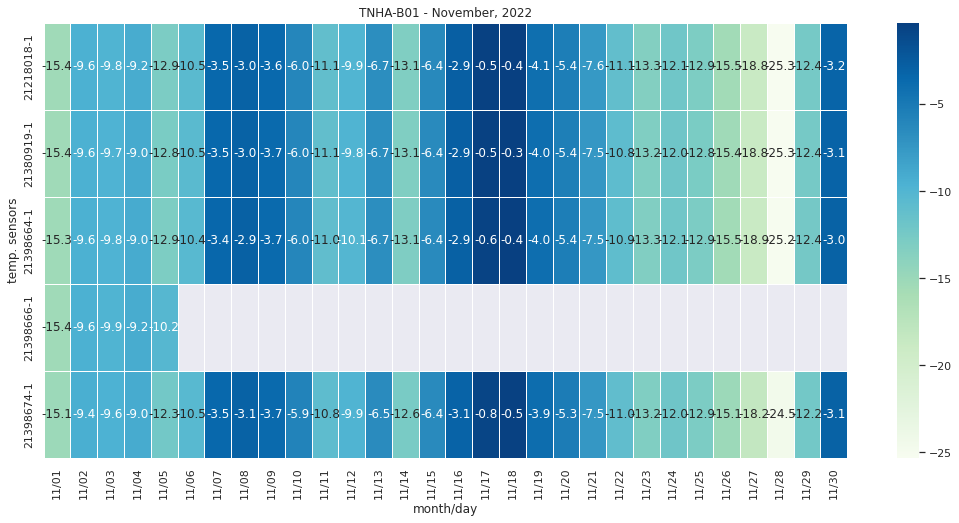

In [28]:
df_temp = df_tnha['2022-11'].groupby('sensor_sn').resample('1D').mean()
df_temp = df_temp.reset_index()
df_temp = df_temp.set_index('timestamp')
df_temp = df_temp.reset_index()
df_temp['timestamp'] =  df_temp['timestamp'].dt.strftime('%m/%d')
df_heatmap = df_temp.pivot_table(index='sensor_sn', 
                                 columns='timestamp',
                                 values='si_value')

graph = sns.heatmap(df_heatmap, annot=True, 
                                fmt='.1f', 
                                linewidth=.5,
                                cmap='GnBu')
plt.xlabel("month/day")
plt.ylabel("temp. sensors")
graph.set_title('TNHA-B01 - November, 2022')

Text(0.5, 1.0, 'TNHA-B01 - December, 2022')

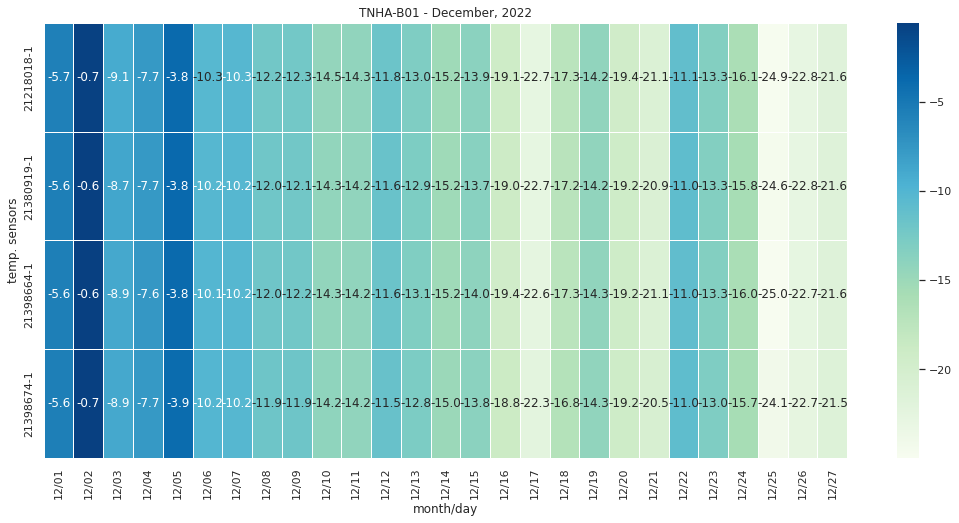

In [29]:
df_temp = df_tnha['2022-12'].groupby('sensor_sn').resample('1D').mean()
df_temp = df_temp.reset_index()
df_temp = df_temp.set_index('timestamp')
df_temp = df_temp.reset_index()
df_temp['timestamp'] =  df_temp['timestamp'].dt.strftime('%m/%d')
df_heatmap = df_temp.pivot_table(index='sensor_sn', 
                                 columns='timestamp',
                                 values='si_value')

graph = sns.heatmap(df_heatmap, annot=True, 
                                fmt='.1f', 
                                linewidth=.5,
                                cmap='GnBu')
plt.xlabel("month/day")
plt.ylabel("temp. sensors")
graph.set_title('TNHA-B01 - December, 2022')

Prepared by: LF Murillo (CC-BY) 02-16-2023